# Keyness analysis per Genre

In [48]:
# This reload library is just used for developing the notebook
# code and can be removed once this is stable.
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.topic_summary import ModelAnalyser, NurGenreMapper, ReviewExtractor

/Users/marijnkoolen/.local/share/virtualenvs/fuzzy-search-KYi4BGOl/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/marijnkoolen/.local/share/virtualenvs/fuzzy-search-KYi4BGOl/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users

#### Set paths and load functions

In [3]:
# please adjust the following paths to reflect the location of the following files in your local directory

impact_file = '../data/review-impact_matches.tsv.gz'
raw_review_data = '../data/reviews-stats.tsv.gz'
isbn_map = "../data/work-isbn-mapping.tsv"
isbn_work_id_mappings_file = "../data/work_isbn_title_genre.tsv.gz"

In [4]:
from impfic_core.map.map_genre import read_genre_file

# read review metadata
review_stats = pd.read_csv(raw_review_data, sep='\t', compression='gzip')

# read work genre mapping
work_genre = read_genre_file(isbn_work_id_mappings_file)

# merge review metadata and genre data
review_stats = pd.merge(review_stats, work_genre[['work_id', 'nur_genre']].drop_duplicates(), 
                        on='work_id', how='left')

# review professional reviews
review_stats = review_stats[review_stats.source != 'NBD_Biblion']


#### Review Statistics

In [5]:
print('number of reviews:', len(review_stats))
review_stats.nur_genre.value_counts() / len(review_stats)

number of reviews: 634614


Literary_fiction      0.305584
Non-fiction           0.149828
Literary_thriller     0.119334
Suspense              0.104566
Other fiction         0.054745
Young_adult           0.045815
Children_fiction      0.039511
Fantasy_fiction       0.020644
Romanticism           0.009847
Historical_fiction    0.005184
Regional_fiction      0.002165
Name: nur_genre, dtype: float64

For log-likelihood ratio ($G^2$) we need:

1. *target corpus*: the total number of words in reviews per genre.
2. *reference corpus*: the total number of words in reviews of all other genres

In [6]:
# compute the total number of review words per genre
review_genre_totals = review_stats.groupby('nur_genre').review_num_words.sum()

# compute the total number of reviews words across all genres
review_genre_totals['Total'] = review_genre_totals.sum()

# rename series to target_freq
review_genre_totals = review_genre_totals.rename('target_freq').to_frame()

# the size of the reference corpus for a given genre is the Total
# number of words minus the number of words of the given genre
review_genre_totals['ref_freq'] = review_genre_totals.loc['Total'] - review_genre_totals

review_genre_totals

,target_freq,ref_freq
nur_genre,,
Children_fiction,3447520,79169103
Fantasy_fiction,2249958,80366665
Historical_fiction,585652,82030971
Literary_fiction,30612003,52004620
Literary_thriller,11765138,70851485
Non-fiction,9893286,72723337
Other fiction,5792310,76824313
Regional_fiction,191498,82425125
Romanticism,984168,81632455


#### Load custom-made classes from `topic_summary.py`

In [7]:
# this class helps to preprocess the inputs and output a genre mapping file
mapper = NurGenreMapper(isbn_map, isbn_work_id_mappings_file)

# this class produces as output the impact_reviews
extractor = ReviewExtractor(impact_file, raw_review_data)

#### Prepare dataset

In [8]:
# get the mapping file which contains `work_id` and `isbn` columns. These are necessary to merge the reviews with the genre information
mapped_df = mapper.process_genre_mapping()

# remove the isbn so each work_id occurs only once
mapped_df = mapped_df[['work_id', 'nur_genre']].drop_duplicates()

# this is our impact reviews dataset:
review_impact = extractor.get_impact_reviews()

# NB. left-join is the best way to merge the files without losing data
review_impact_with_genre = pd.merge(review_impact, mapped_df, on = 'work_id', how = 'left')

Dataset consists of impact terms extracted from the reviews of books by the impact model and scored according to affect, style, narrative and reflection. 

In [9]:
dt = review_impact_with_genre
dt.head()

,work_id,review_id,affect,style,narrative,reflection,impact_term,review_num_words,nur_genre
0,impfic-work-3723,impfic-review-1,1,0,0,0,fantastisch,185,Young_adult
1,impfic-work-3723,impfic-review-1,1,0,1,0,fantastisch,185,Young_adult
2,impfic-work-3723,impfic-review-1,1,0,1,0,spanning,185,Young_adult
3,impfic-work-36913,impfic-review-2,1,1,0,0,prachtig,185,Literary_fiction
4,impfic-work-31725,impfic-review-3,1,0,0,0,leuk,217,Children_fiction


In [10]:
# there are 2.4 million impact matches. 
# Check that the DataFrame has the correct shape
dt.shape

(2423421, 9)

## Compute keyness

For keyness we use log-likelihood ratio ($G^2$). 

- `compute_keyword_category_freq` computes the frequency of an impact term (keyword) in the reviews of each genre.
- `compute_keyness` computes $G^2$ per impact term per genre.

In [11]:
from src.keyness import compute_category_totals, compute_keyword_category_freq, compute_keyness

impact_types = ['affect', 'style', 'narrative']

key_cat_freq = {}
#key_cat_totals = {}
for impact_type in impact_types:
    key_cat_freq[impact_type] = compute_keyword_category_freq(dt[dt[impact_type] == 1], 'nur_genre', 'impact_term')
    #key_cat_totals[impact_type] = compute_category_totals(key_cat_freq[impact_type])



In [12]:
# a list of all the genres
genres = [
    'Children_fiction', 'Fantasy_fiction', 'Historical_fiction',
    'Literary_fiction', 'Literary_thriller', 'Non-fiction', 'Other fiction',
    'Regional_fiction', 'Romanticism', 'Suspense', 'Young_adult'
]

In [13]:
# Gather keyness per genre per impact type
df_list = []

for impact_type in impact_types:
    impact_keyness = pd.DataFrame()
    # compute keyness per genre and add to DataFrame
    for genre in genres:
        impact_keyness[genre] = compute_keyness(key_cat_freq[impact_type], review_genre_totals, genre)
    # add a column with the impact type
    impact_keyness['impact_type'] = impact_type
    df_list.append(impact_keyness)

# concatenate the list of data frames
keyness = pd.concat(df_list)

# check that we have scores per impact term (row) and per genre (column)
# with a column indicating the impact type
keyness

,Children_fiction,Fantasy_fiction,Historical_fiction,Literary_fiction,Literary_thriller,Non-fiction,Other fiction,Regional_fiction,Romanticism,Suspense,Young_adult,impact_type
impact_term,,,,,,,,,,,,
(ik|je) (hoopte|hoopt),0.031868,0.330552,0.560184,0.097621,4.323039,55.272392,0.743246,0.052305,4.586910,5.726783,7.001754,affect
(ik|je|lezer) (voelt|voelde),12.553795,2.990394,17.587846,35.291894,0.743702,165.154772,0.071421,13.229215,28.521251,5.392594,21.768692,affect
(in).+(één|een|1).+(adem|avond|dag|keer|middag|ruk|stuk|zucht).+(gelezen|uitgelezen|uit),13.865281,4.340335,2.040570,10.629500,91.395291,82.194818,10.433333,14.472759,24.930595,2.088455,2.337103,affect
(laat|liet|lieten).+(mij|me|je|lezer).+(niet).+(los),37.015253,6.258918,2.208710,21.598768,21.176537,218.895401,6.908899,1.314820,10.082703,26.738381,0.306249,affect
(neem*|nam).+(je|me|lezer|ons).+(mee),3.349400,0.794423,8.362241,2.711334,14.158813,3.538331,6.714604,0.513517,3.944340,1.220295,9.948126,affect
...,...,...,...,...,...,...,...,...,...,...,...,...
verrassing,9.283770,1.840202,5.546161,383.590397,457.993092,184.255737,55.484416,1.664820,4.354343,400.180651,0.389964,narrative
verrast,0.596747,0.386560,0.099597,0.224284,0.000012,0.033663,1.017656,0.032488,0.167776,3.524600,1.006030,narrative
verslavend,12.187111,46.168153,0.808293,10.881048,17.444706,91.013099,18.041264,0.064487,1.676168,0.443494,42.607144,narrative


$G^2$ is a test for statistical significance. We need a threshold for considering an impact term a _key_ term.

From the literature, we take the following log-likelihood (LL) thresholds corresponding to p-values:

- $p < 0.05$ corresponds to $LL > 3.84$
- $p < 0.01$ corresponds to $LL > 6.63$
- $p < 0.001$ corresponds to $LL > 10.83$

In Corpus Linguistics, the typical p-value = $p<0.01$, so we use the LL threshold 6.63.

In [14]:
LL_threshold = 6.63

### Percent Difference

The log-likelihood is used as a filter to select only impact terms that are _key_ terms. We also want to measure effect size to see which _key_ terms have a large percent difference between their relative frequency in the _target_ corpus and their relative frequency in the _reference_ corpus.

In [15]:
from src.keyness import compute_percent_diff

df_list = []

for impact_type in impact_types:
    impact_percent_diff = compute_percent_diff(key_cat_freq[impact_type], review_genre_totals)
    impact_percent_diff['impact_type'] = impact_type
    df_list.append(impact_percent_diff)

percent_diff = pd.concat(df_list)

# check that we have percent differences per impact term (row) adn per genre (column)
# and a column indicating the impact type
percent_diff

,Children_fiction,Fantasy_fiction,Historical_fiction,Literary_fiction,Literary_thriller,Non-fiction,Other fiction,Regional_fiction,Romanticism,Suspense,Young_adult,impact_type
impact_term,,,,,,,,,,,,
(ik|je) (hoopte|hoopt),-2.640794,10.706680,-25.297188,-1.908502,18.531305,-57.366870,-9.825566,14.474176,64.545024,21.792886,33.046853,affect
(ik|je|lezer) (voelt|voelde),-18.790528,-11.458424,60.146334,14.361006,2.739953,-39.146636,1.156726,94.452349,59.273734,-7.290863,21.129554,affect
(in).+(één|een|1).+(adem|avond|dag|keer|middag|ruk|stuk|zucht).+(gelezen|uitgelezen|uit),13.113425,-8.651897,-11.463268,-4.551185,19.747528,-18.298986,8.854400,59.143849,33.340337,-2.861415,-4.098895,affect
(laat|liet|lieten).+(mij|me|je|lezer).+(niet).+(los),-52.819762,31.921517,36.891881,20.525933,27.734119,-71.318369,-19.386155,50.497518,-51.550438,31.888219,-4.247297,affect
(neem*|nam).+(je|me|lezer|ons).+(mee),-18.470745,11.723651,80.853312,7.365145,-21.280975,12.515691,22.252809,32.846575,40.900077,-6.607736,-24.602060,affect
...,...,...,...,...,...,...,...,...,...,...,...,...
verrassing,-19.230093,11.165878,-34.468379,-43.398341,99.724205,-47.862980,-35.219750,-33.083328,26.357408,93.199067,-3.206157,narrative
verrast,-100.000000,-100.000000,-100.000000,-32.046760,0.369251,22.512946,-100.000000,-100.000000,-100.000000,370.127159,-100.000000,narrative
verslavend,60.270097,161.268852,-31.473693,-19.567542,41.144259,-72.527400,-46.248607,-16.015043,39.611491,-5.939471,94.522892,narrative


### Selecting significant terms

Next, we filter the percent difference scores using the corresponding $G^2$ scores.

In [16]:
selected_diff_freq = pd.DataFrame()
df_list = []

for impact_type in impact_types:
    selected_diff = {}
    selected_freq = {}
    impact_selected_diff_freq = {}
    genre_df_list = []
    impact_keyness = keyness[keyness.impact_type == impact_type]
    impact_percent_diff = percent_diff[percent_diff.impact_type == impact_type]
    for genre in genres:
        key_impact_terms = impact_keyness[genre][impact_keyness[genre] > LL_threshold].index
        
        selected_diff[genre] = impact_percent_diff[genre].loc[key_impact_terms].rename('%Diff')
        
        selected_freq[genre] = key_cat_freq[impact_type][genre].loc[key_impact_terms].rename('Freq')
        genre_selected_diff_freq = pd.concat([selected_diff[genre], selected_freq[genre]], axis=1).reset_index()
        
        # add column with genre label
        genre_selected_diff_freq['genre'] = genre
        genre_df_list.append(genre_selected_diff_freq)
    impact_selected_diff_freq = pd.concat(genre_df_list)
    impact_selected_diff_freq['impact_type'] = impact_type
    df_list.append(impact_selected_diff_freq)

significant_diff_freq = pd.concat(df_list)
        
significant_diff_freq

,impact_term,%Diff,Freq,genre,impact_type
0,(ik|je|lezer) (voelt|voelde),-18.790528,281.0,Children_fiction,affect
1,(in).+(één|een|1).+(adem|avond|dag|keer|middag...,13.113425,994.0,Children_fiction,affect
2,(laat|liet|lieten).+(mij|me|je|lezer).+(niet)....,-52.819762,52.0,Children_fiction,affect
3,(raakt|raken|raakte|raakten).+(me|mij|je|lezer),-31.889785,162.0,Children_fiction,affect
4,(spreekt|spreken|sprak|spraken).+(me).+(aan),-42.377970,34.0,Children_fiction,affect
...,...,...,...,...,...
57,verplaatsen,44.833829,595.0,Young_adult,narrative
58,verrassen,-16.377035,1479.0,Young_adult,narrative
59,verrassend,-50.027299,85.0,Young_adult,narrative
60,verslavend,94.522892,130.0,Young_adult,narrative


The $G^2$ score tells us if a term has a significantly different relative frequency in the _target_ corpus with respect to the _reference_ corpus, but does not tell us whether it is relatively _more_ or _less_ frequent.

For that, we add a column `sign` indicating whether the percent difference is positive (more likely) or negative (less likely).

In [17]:
significant_diff_freq.shape, significant_diff_freq.replace([np.inf, -np.inf], np.nan).dropna().shape
significant_diff_freq['sign'] = significant_diff_freq['%Diff'].apply(lambda x: 'positive %Diff' if x > 0 else 'negative %Diff')
significant_diff_freq

,impact_term,%Diff,Freq,genre,impact_type,sign
0,(ik|je|lezer) (voelt|voelde),-18.790528,281.0,Children_fiction,affect,negative %Diff
1,(in).+(één|een|1).+(adem|avond|dag|keer|middag...,13.113425,994.0,Children_fiction,affect,positive %Diff
2,(laat|liet|lieten).+(mij|me|je|lezer).+(niet)....,-52.819762,52.0,Children_fiction,affect,negative %Diff
3,(raakt|raken|raakte|raakten).+(me|mij|je|lezer),-31.889785,162.0,Children_fiction,affect,negative %Diff
4,(spreekt|spreken|sprak|spraken).+(me).+(aan),-42.377970,34.0,Children_fiction,affect,negative %Diff
...,...,...,...,...,...,...
57,verplaatsen,44.833829,595.0,Young_adult,narrative,positive %Diff
58,verrassen,-16.377035,1479.0,Young_adult,narrative,negative %Diff
59,verrassend,-50.027299,85.0,Young_adult,narrative,negative %Diff
60,verslavend,94.522892,130.0,Young_adult,narrative,positive %Diff


In [18]:
# use a short label for convenience
sdf = significant_diff_freq

# sort terms with a positive %Diff by value to identify 
# significant _key_ terms with low effect size
sdf[sdf.sign == 'positive %Diff'].sort_values('%Diff').head(50)

,impact_term,%Diff,Freq,genre,impact_type,sign
15,boeiend,6.900120,1901.0,Suspense,affect,positive %Diff
31,prachtig,7.230001,2545.0,Children_fiction,style,positive %Diff
84,prachtig,7.230001,2545.0,Children_fiction,affect,positive %Diff
34,gevoel,7.505657,3909.0,Other fiction,affect,positive %Diff
33,genieten,7.661777,1779.0,Other fiction,affect,positive %Diff
34,spanning,7.774401,1859.0,Fantasy_fiction,narrative,positive %Diff
71,spanning,7.774401,1859.0,Fantasy_fiction,affect,positive %Diff
33,mee in,7.843297,3155.0,Literary_fiction,narrative,positive %Diff
68,mee in,7.843297,3155.0,Literary_fiction,affect,positive %Diff
47,heftig,8.724172,4295.0,Literary_fiction,affect,positive %Diff


The impact term with the lowest effect size (%Diff) is "boeiend" (EN: intriguing), for the genre _Suspense_ and with the impact type _affect_, with a %Diff of 6.9%.

Let's check the relative frequencies and the $G^2$ score:

In [19]:
genre = 'Suspense'
impact_type = 'affect'
impact_term = 'boeiend'

# relative freq of boeiend in the target corpus
frac_target = key_cat_freq[impact_type].loc[impact_term][genre] / review_genre_totals.target_freq.loc[genre]

# relative frequency of boeiend in the reference corpus
frac_ref = (key_cat_freq[impact_type].loc[impact_term]['Total'] - 
            key_cat_freq[impact_type].loc[impact_term][genre]) / review_genre_totals.ref_freq.loc[genre]

#
print('relative freq. in target corpus:', frac_target)
print('relative freq. in reference corpus:', frac_ref)
print('ratio:', frac_target / frac_ref)
print('%Diff:', 100 * (frac_target - frac_ref) / frac_ref)

relative freq. in target corpus: 0.00016724426495573702
relative freq. in reference corpus: 0.00015644908987036705
ratio: 1.0690012009294192
%Diff: 6.900120092941928


In [20]:
print('Log-likelihood ratio:', keyness[keyness.impact_type == 'affect'].loc['boeiend']['Suspense'])

Log-likelihood ratio: 7.118406045084242


### Writing Key Impact Terms to HTML Tables

In [84]:
sdf_table = (sdf[sdf.sign == 'positive %Diff']
             .sort_values(['genre', 'impact_type', '%Diff'], ascending=False)
             .groupby(['genre', 'impact_type'])
             .head(10)
             .set_index(['genre', 'impact_type', 'impact_term'])
             .to_html()
)

with open('../data/key_impact_terms-more_likely_per_genre.md', 'wt') as fh:
    fh.write(sdf_table)

temp.set_index(['genre', 'impact_type', 'impact_term'])


sdf_table = (sdf[sdf.sign == 'negative %Diff']
             .sort_values(['genre', 'impact_type', '%Diff'], ascending=True)
             .groupby(['genre', 'impact_type'])
             .head(10)
             .set_index(['genre', 'impact_type', 'impact_term'])
             .to_html()
)

with open('../data/key_impact_terms-less_likely_per_genre.md', 'wt') as fh:
    fh.write(sdf_table)


For figures and tables, we want more readable names and short hands for showing columns with all genre names.

In [21]:
genre_map_short = {
    'Children_fiction': 'Child. fic',
    'Fantasy_fiction': 'Fantasy',
    'Historical_fiction': 'Hist. fic',
    'Literary_fiction': 'Lit. fic',
    'Literary_thriller': 'Lit. thrill',
    'Non-fiction': 'Non-fic',
    'Other fiction': 'Oth. fic',
    'Regional_fiction': 'Reg. fic',
    'Romanticism': 'Romance',
    'Suspense': 'Suspense',
    'Young_adult': 'YA',
}

genre_map_print = {
    'Children_fiction': "Children's fiction",
    'Fantasy_fiction': 'Fantasy fiction',
    'Historical_fiction': 'Historical fiction',
    'Literary_fiction': 'Literary fiction',
    'Literary_thriller': 'Literary thriller',
    'Non-fiction': 'Non-fiction',
    'Other fiction': 'Other fiction',
    'Regional_fiction': 'Regional fiction',
    'Romanticism': 'Romance',
    'Suspense': 'Suspense',
    'Young_adult': 'Young Adult',
}


### Plotting the fraction of _key_ impact terms per genre


In [22]:
# Number of impact terms per impact type derived from the 
# rules of the Dutch Reading Impact Model
num_impact_terms = {
    'affect': 149,
    'narrative': 85,
    'style': 56
}


In [36]:
num_terms_genre = sdf.groupby(['impact_type', 'genre', 'sign']).sign.count().unstack()
num_terms_genre.reset_index().to_csv('../data/num_key_terms-genre.tsv', sep='\t', index=False)

In [38]:
num_terms_genre = pd.read_csv('../data/num_key_terms-genre.tsv', sep='\t')
num_terms_genre = num_terms_genre.set_index(['impact_type', 'genre'])

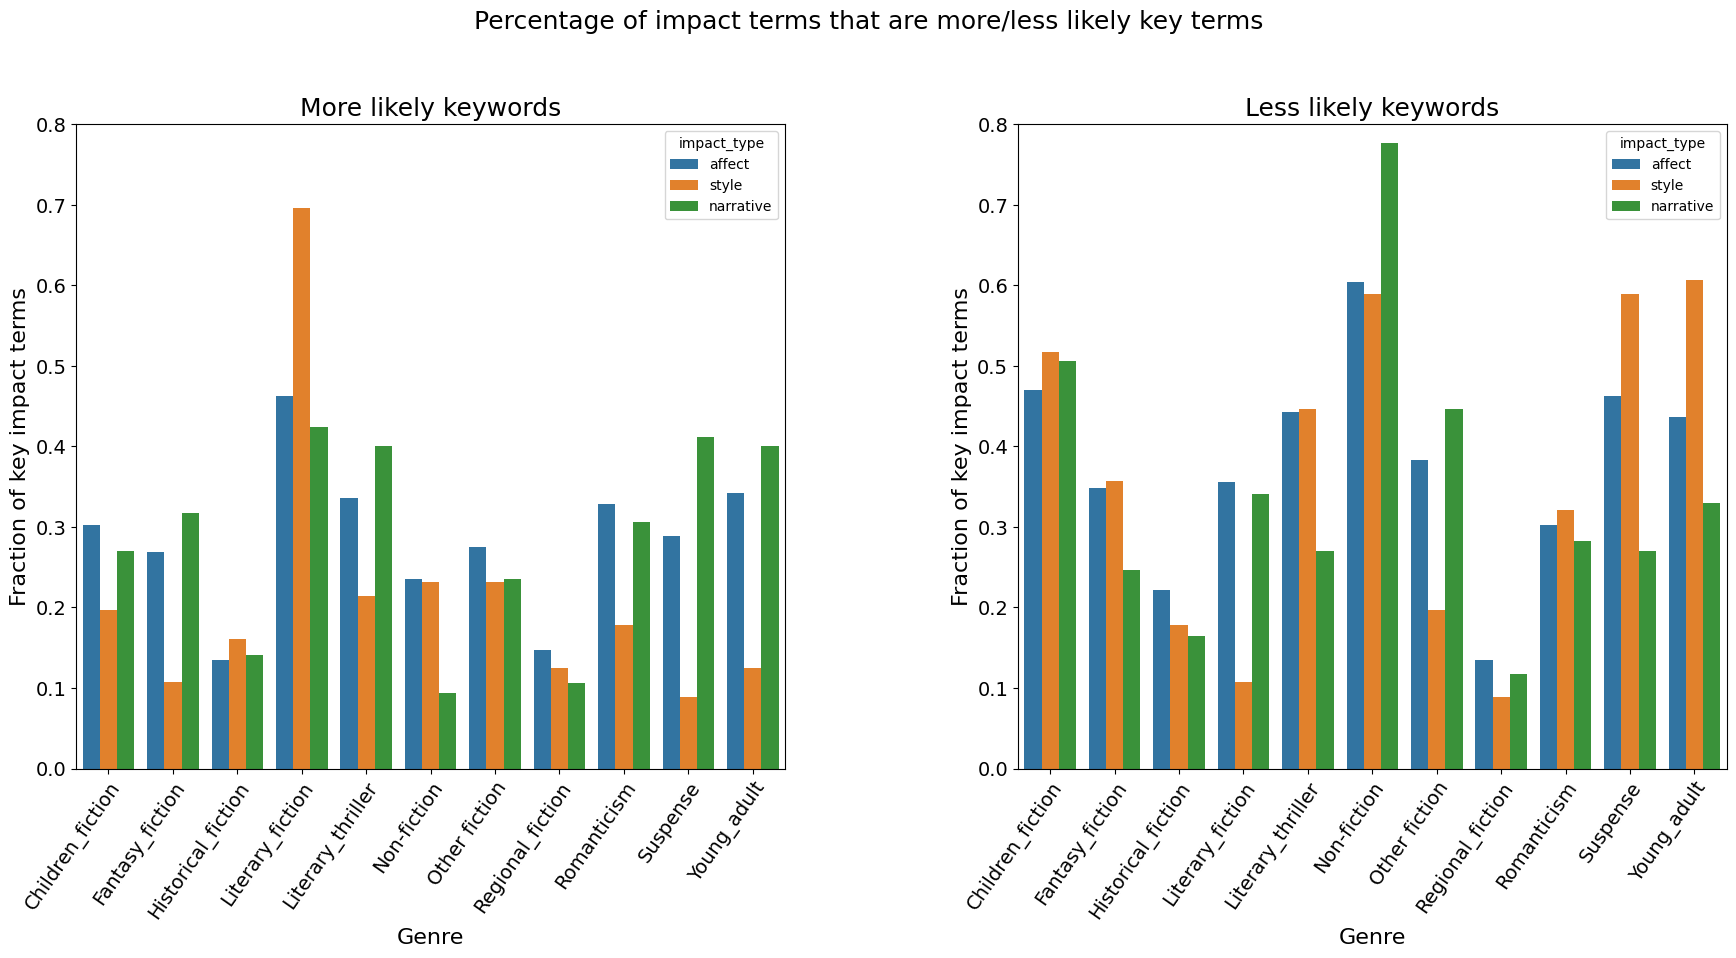

In [47]:
df_list = []
for impact_type in impact_types:
    # the number of _key_ terms per genre divided by the total number of impact terms 
    # for the given impact type
    impact_terms_frac = num_terms_genre.loc[impact_type] / num_impact_terms[impact_type]
    # add a column with the impact type
    impact_terms_frac['impact_type'] = impact_type
    df_list.append(impact_terms_frac)

# concatenate the fraction of key impact terms per impact type
# into a single data frame
impact_terms_frac = pd.concat(df_list)

# plot bar charts for the fractions of positive (more likely) and negative 
# (less likely) terms per genre and per impact type
fig, ax = plt.subplots(1, 2)
sns.barplot(data=impact_terms_frac.reset_index(), x='genre', y='positive %Diff', hue='impact_type', ax=ax[0])
sns.barplot(data=impact_terms_frac.reset_index(), x='genre', y='negative %Diff', hue='impact_type', ax=ax[1])

ax[0].set_title('More likely keywords', fontsize=18)
ax[1].set_title('Less likely keywords', fontsize=18)

ax[0].set_xlabel('Genre', fontsize=16)
ax[1].set_xlabel('Genre', fontsize=16)
ax[0].set_ylabel('Fraction of key impact terms', fontsize=16)
ax[1].set_ylabel('Fraction of key impact terms', fontsize=16)

ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].tick_params(axis='x', labelrotation=55)
ax[1].tick_params(axis='x', labelrotation=55)

# rotates labels and aligns them horizontally to left
# source: https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label
plt.setp( ax[0].xaxis.get_majorticklabels(), rotation=55, ha="right", rotation_mode="anchor") 
plt.setp( ax[1].xaxis.get_majorticklabels(), rotation=55, ha="right", rotation_mode="anchor") 

ax[0].set_ylim(0, 0.8)
ax[1].set_ylim(0, 0.8)

fig.suptitle('Percentage of impact terms that are more/less likely key terms', fontsize=18)


# Ensure there is enough horizontal space between the two plots
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=None)

fig.set_size_inches(18, 10)
plt.tight_layout(w_pad=12, pad=3)

fig.savefig('../images/num_key_terms_per_genre.png', dpi=150)

### Plot correlations of %Diff scores between genres

Each impact term has a %Diff score for each genre. Some genres might have similar %Diff scores for the same impact terms. A Pearson correlation ($\rho$) score is a crude measure, but it gives an indication of the similarity or difference between two pairs of genres. 

In [39]:
# Use the dataframe_image package to save correlation tables as images
import dataframe_image as dfi

In [40]:
# Correlations between genres for affective imapct terms
dfi.export(percent_diff[percent_diff.impact_type == 'affect']
 .rename(columns=genre_map_short)
 #.drop(['Non-fic', 'Oth. fic'], axis=1)
 .drop('impact_type', axis=1)
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None), '../images/percent_diff_corr/percent_diff_corr-genre-affect.png', dpi=150)

In [41]:
# Correlations between genres for narrative impact terms
dfi.export(percent_diff[percent_diff.impact_type == 'narrative']
 .rename(columns=genre_map_short)
 #.drop('impact_type', axis=1)
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None), '../images/percent_diff_corr/percent_diff_corr-genre-narrative.png', dpi=150)

/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_73565/2928534879.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  .corr()


In [42]:
# Correlations between genres for stylistic impact terms
dfi.export(percent_diff[percent_diff.impact_type == 'style']
 .rename(columns=genre_map_short)
 #.drop('impact_type', axis=1)
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None), '../images/percent_diff_corr/percent_diff_corr-genre-style.png', dpi=150)

/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_73565/3597613896.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  .corr()


### Plotting %Diff and frequency of _key_ impact terms

In [714]:
import matplotlib.pyplot as plt
from adjustText import adjust_text


def plot_freq_diff(sdf, impact_type, genre, topn=10):
    sdf = sdf[(sdf.impact_type == impact_type) & (sdf.genre == genre)]
    top_sdf = pd.concat([
        sdf.sort_values('%Diff').tail(topn), 
        sdf.sort_values('%Diff').head(topn)
    ])
    sign_order = ['positive %Diff', 'negative %Diff']
    ax = sns.scatterplot(data=sdf, x='Freq', y='%Diff', hue='sign', hue_order=sign_order)
    ax.set_xlim(1,sdf.Freq.max())
    ax.set_xscale('log')

    num_pos_terms = len(sdf[sdf.sign == 'positive %Diff'])
    num_neg_terms = len(sdf[sdf.sign == 'negative %Diff'])
    
    plt.axhline(y=0.0, color='gray', linestyle='-')
    
    x = list(top_sdf['Freq'])
    y = list(top_sdf['%Diff'])
    labels = list(top_sdf['impact_term'])
    
    ax.set_xlabel(f'Impact term frequency of {num_pos_terms} positive and {num_neg_terms} negative keywords')
    ax.set_title(f'key {impact_type.title()} impact terms of {genre_map_print[genre]}')
    
    texts = [plt.text(x[i], y[i], labels[i]) for i in range(len(x))]
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    
    ax.figure.savefig(f'../images/percent_diff/percent_diff-{impact_type}-{genre}.png', dpi=150)
    plt.show()



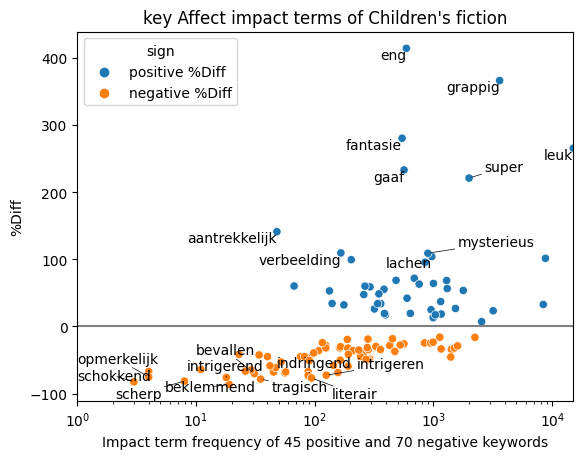

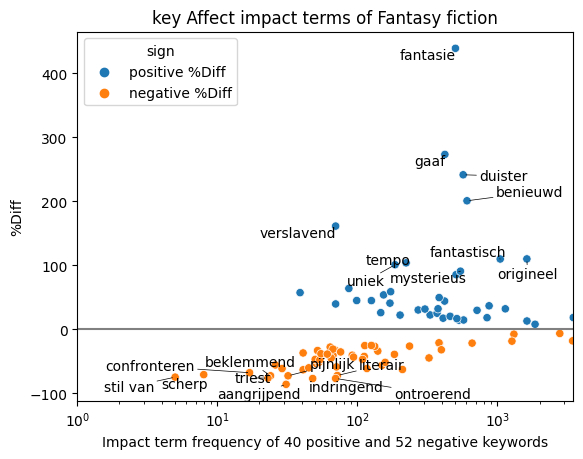

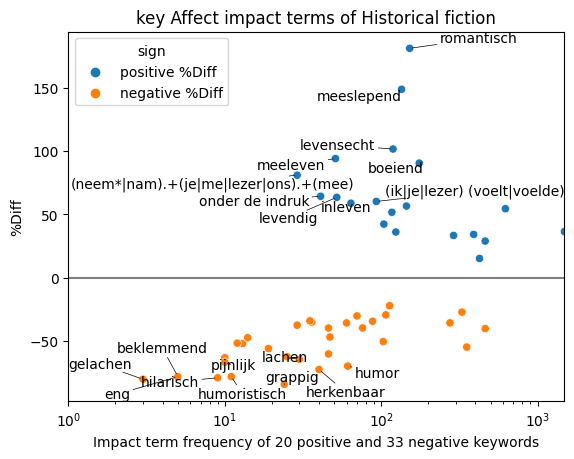

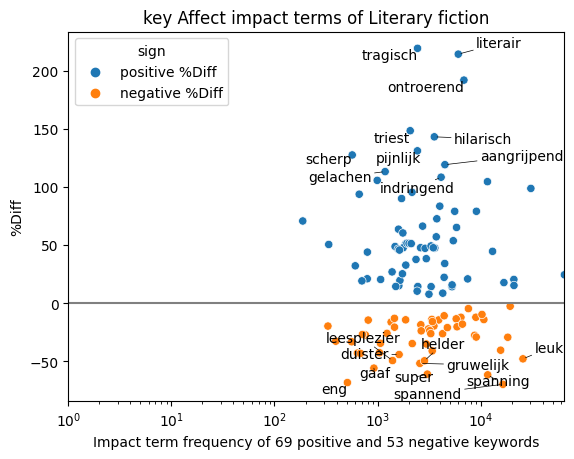

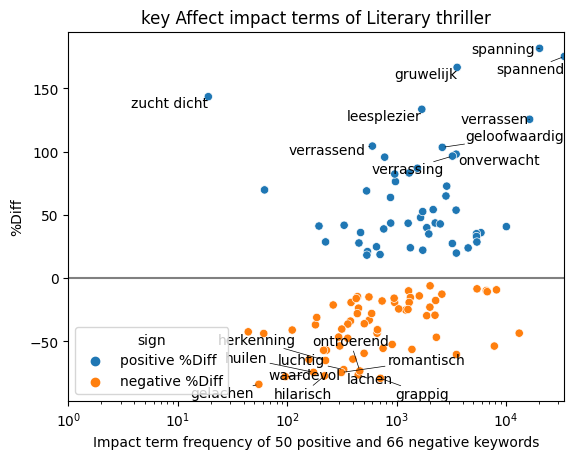

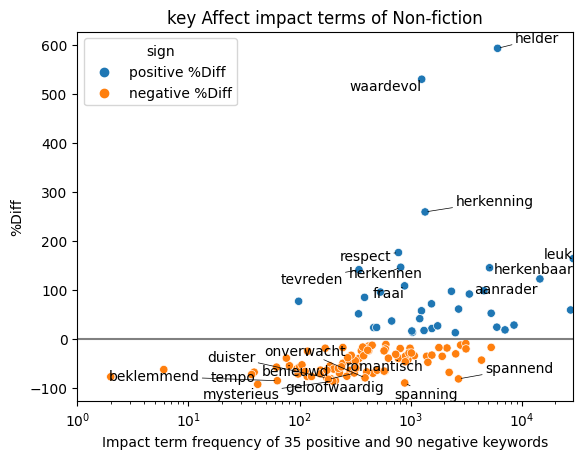

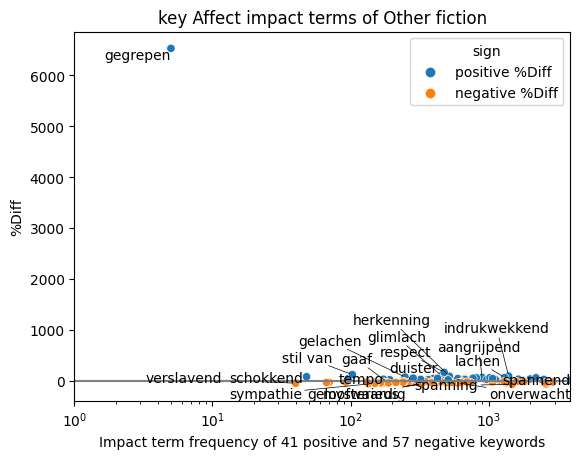

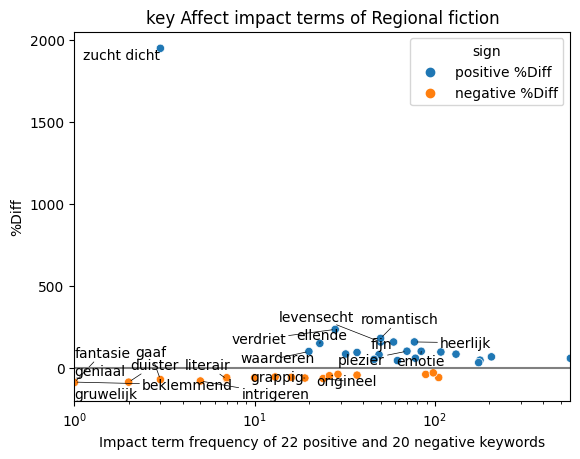

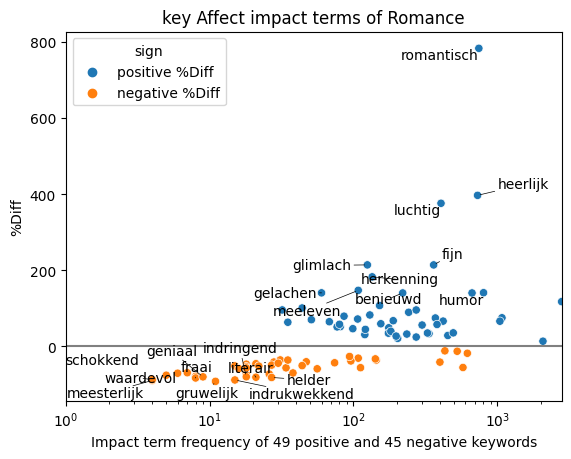

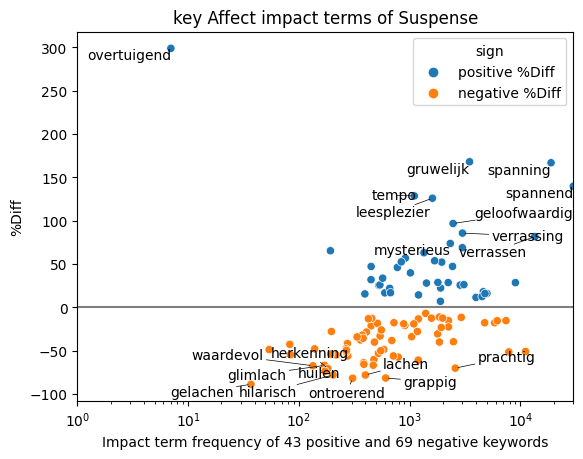

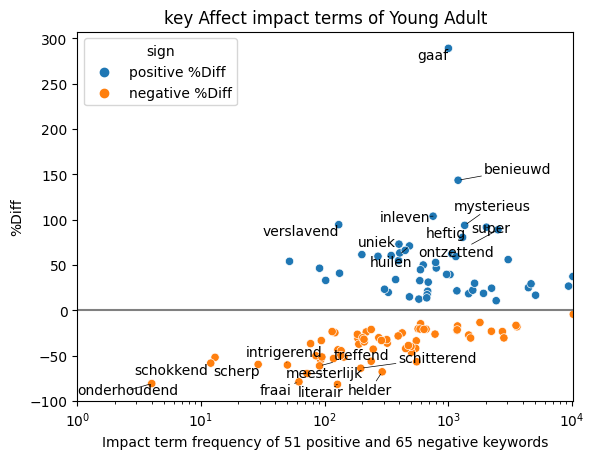

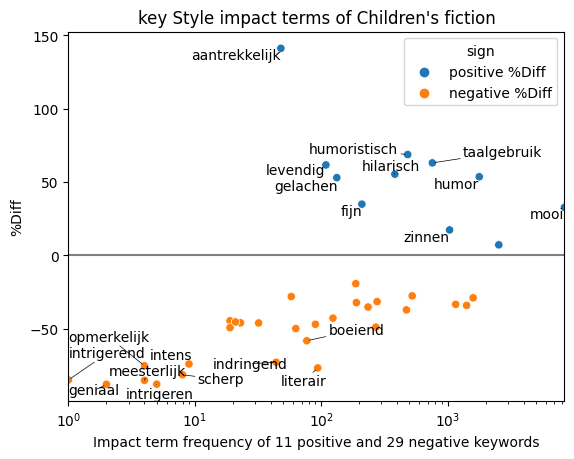

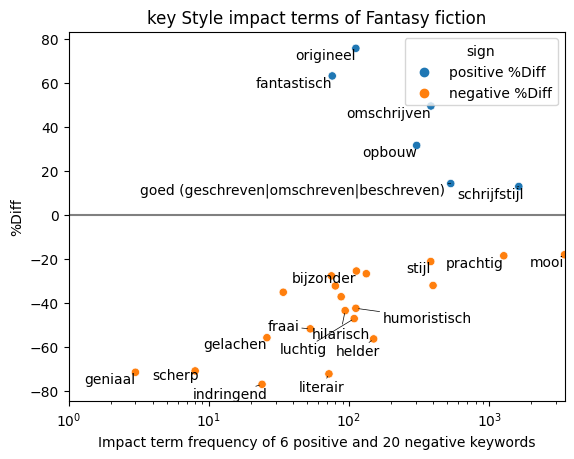

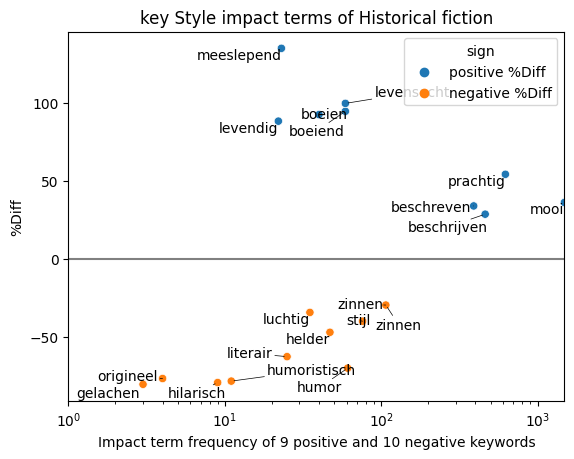

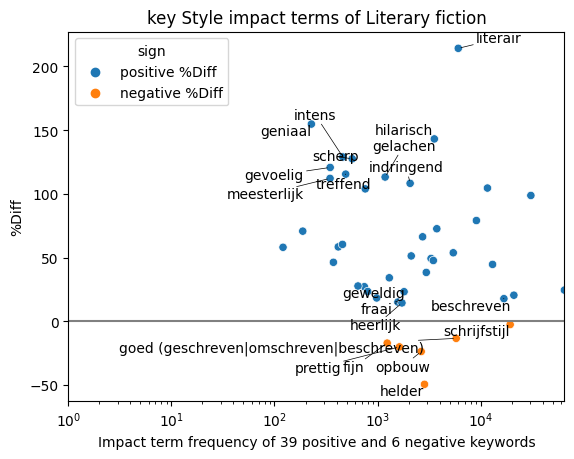

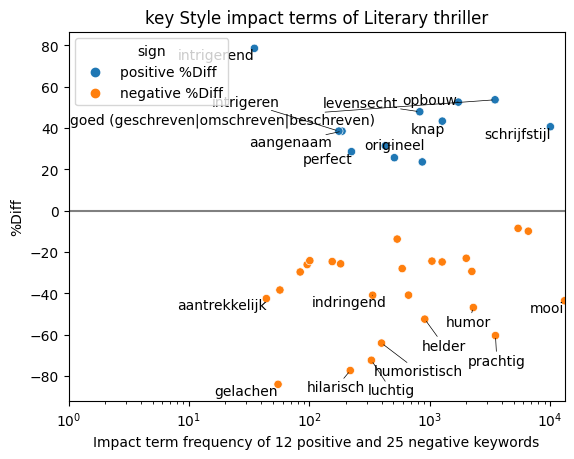

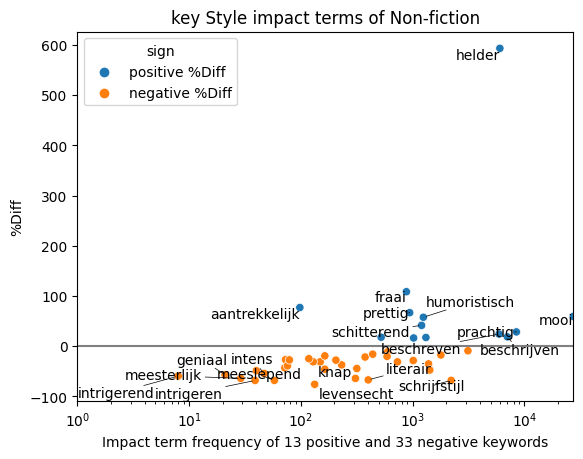

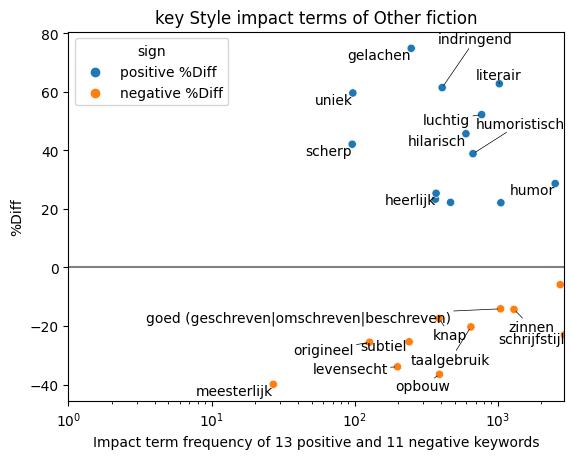

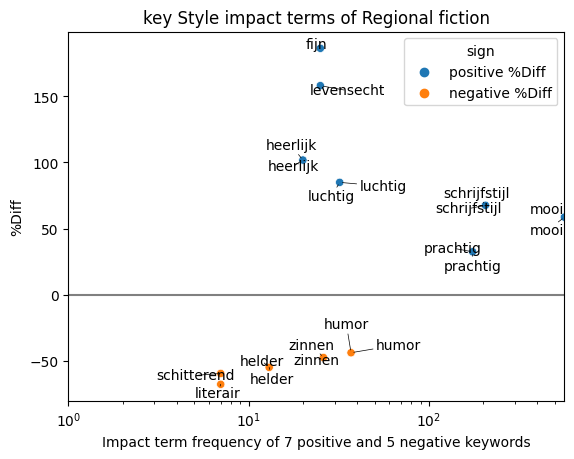

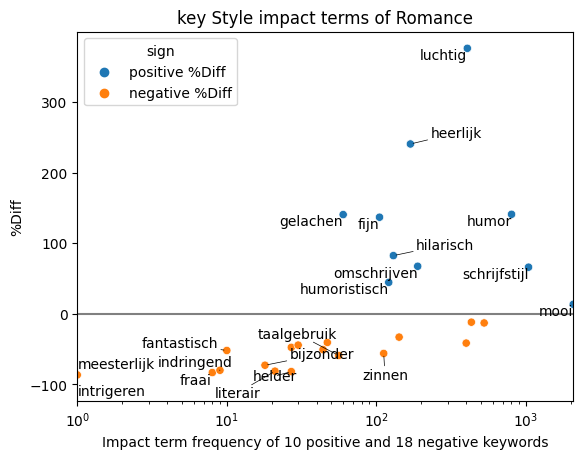

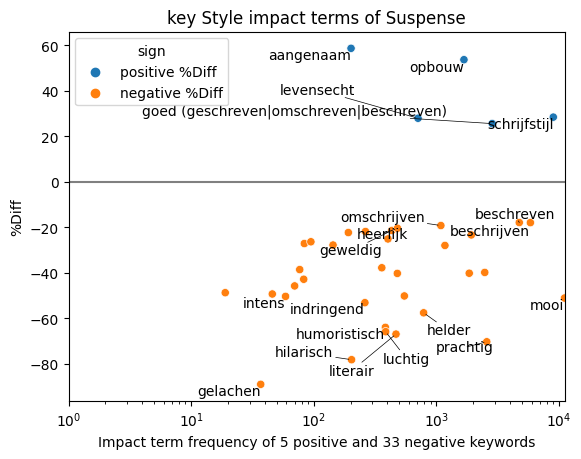

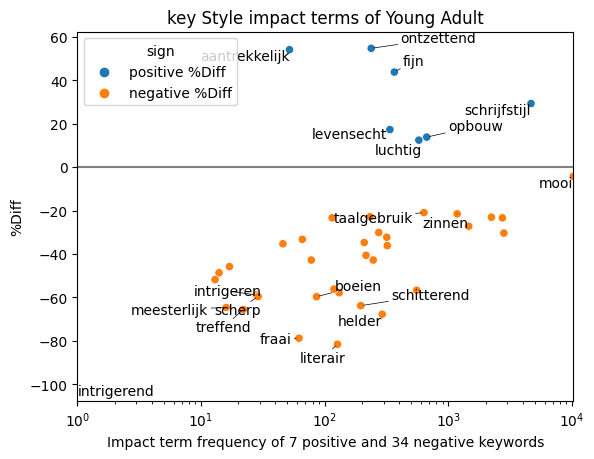

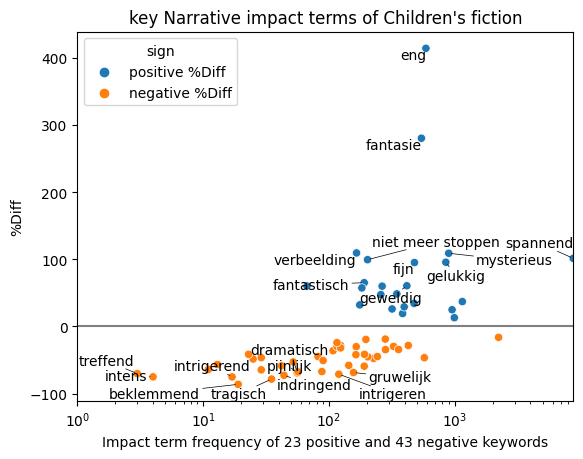

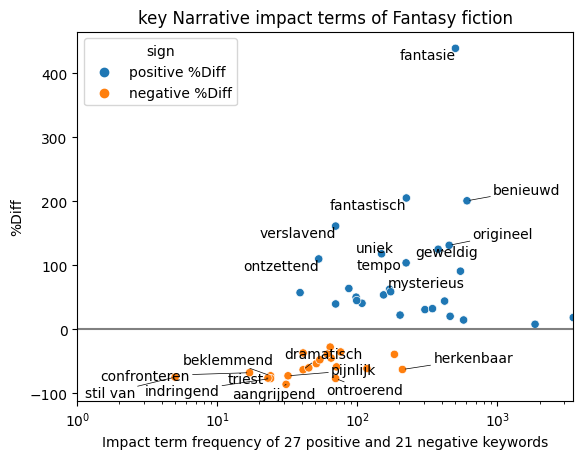

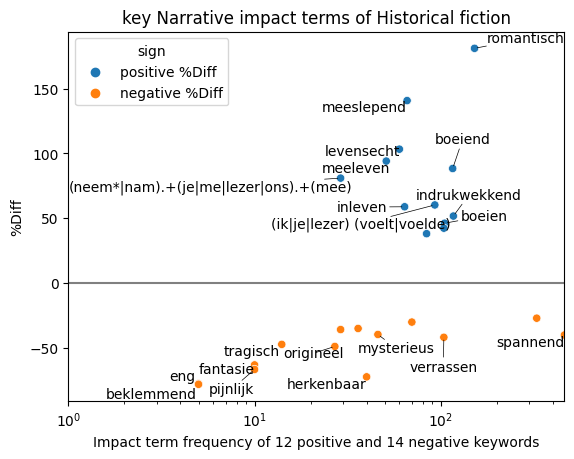

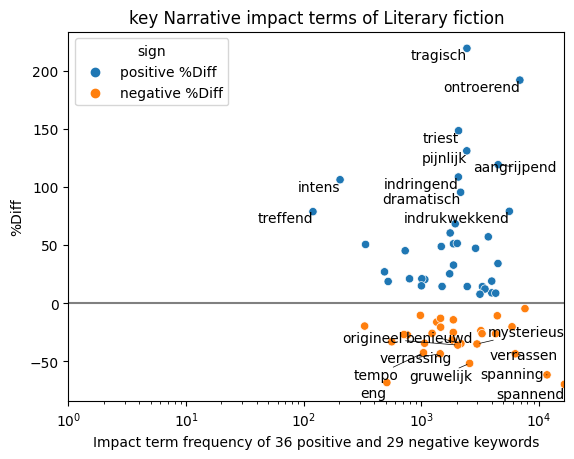

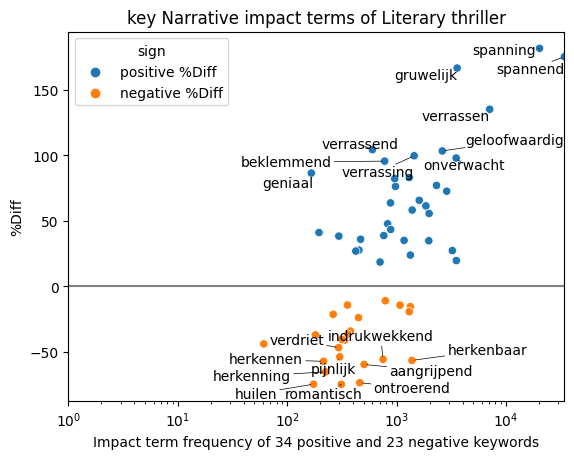

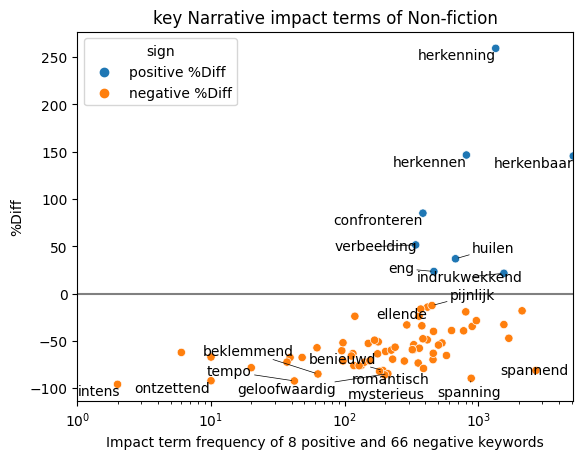

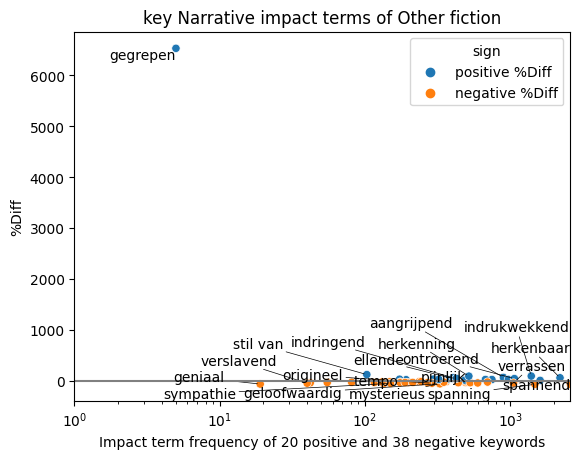

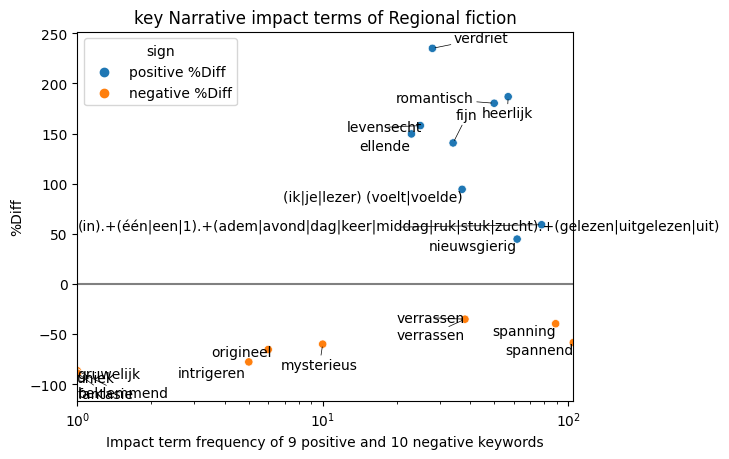

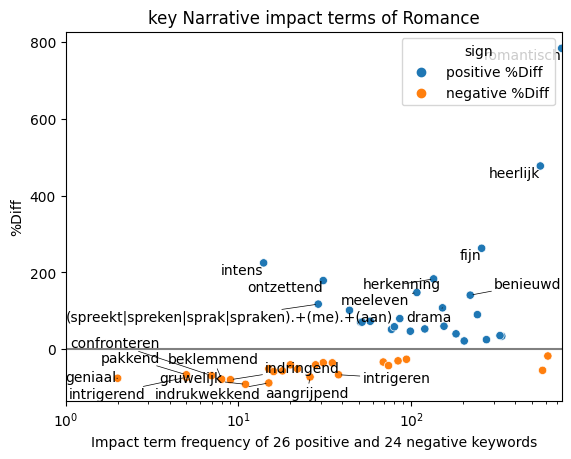

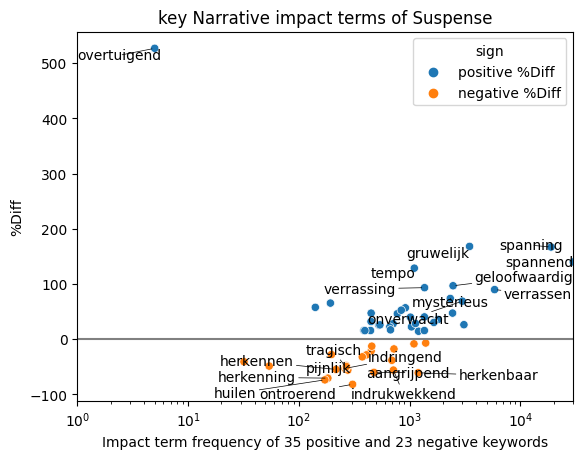

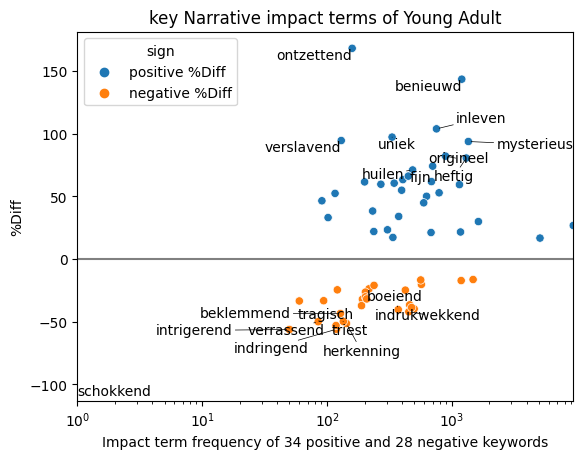

In [683]:
for impact_type in impact_types:
    for genre in genres:
        plot_freq_diff(sdf, impact_type, genre, topn=10)